# Cross Validation
* 목적
    1. Overfitting, underfitting을 피하기 위해
        * Overfitting : training set에 대한 정확도는 매우 높으나 validation set에 대한 정확도는 많이 떨어지는 경우
            1. 특성변수의 갯수 축소
            2. 규제화 강도 강화
            3. 전체 관측자료 증가(하지만 sample size를 늘리는 건 쉽지 않다)
        * Underfitting : 정확도가 아예 많이 떨어지는 경우
            1. 특성변수의 갯수 증가
            2. 규제화 강도 약화
            3. 다른 모델을 사용해보기
    2. Hyperparameter의 결정
    3. 모형간 성능 비교
    
![goodness](goodness.png)
    
* 과정
    1. 전체 data를 training set + validation set + test set으로 구분
    2. 초모수의 결정을 위해 training set과 validation set 사용
        * 이때 우연히 좋거나 나쁜 validation set이 선택되는 것을 방지하기 위해 K-fold Cross Validation 수행
        * validation set에 unbiased한 초모수를 찾는 과정
    3. 초모수가 결정되면 test set으로 성능 평가
        * 학습된 모형의 performance가 자료 분할에 의존되어버리는 것을 방지하기 위해 또 다시 Cross Validation 수행
    4. 종합하면 다음과 같은 Nested Cross Validation 형태가 된다.
        * Inner loop에서 parameter tuning을 거친 후 outer loop에서 학습된 모형의 performance 평가
        * 이때 outer loop에서 성능 평가에 사용되는 초모수들이 항상 같지 않다.
![nested CV](ncv.png)
    

In [1]:
import time

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [2]:
# 미국 Boston 지역의 집값 data 불러오기
boston=pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                     'python-machine-learning-book-2nd-edition'
                     '/master/code/ch10/housing.data.txt',header=None,sep='\s+')
boston.columns=['CRIM', 'ZN', 'INDUS', 'CHAS','NOX', 'RM', 'AGE', 'DIS', 'RAD','TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

In [3]:
boston['LLSTAT']=np.log(boston['LSTAT'])
boston['LINDUS']=np.log(boston['INDUS'])
boston1=boston.drop(['LSTAT','INDUS','MEDV'],axis=1)

In [4]:
X=boston1.values
y=boston['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

### KneighborsRegressor

In [39]:
pipe_knr = make_pipeline(StandardScaler(), KNeighborsRegressor())
knr_nb=[2,3,4,5,6,7,8]
knr_wt=['uniform', 'distance']
knr_alg=['auto', 'ball_tree', 'kd_tree', 'brute']
grid_knr={'kneighborsregressor__n_neighbors':knr_nb,
          'kneighborsregressor__weights':knr_wt,
          'kneighborsregressor__algorithm':knr_alg}
CV_knr=GridSearchCV(estimator=pipe_knr, param_grid=grid_knr, cv=10)

In [40]:
startTime = time.time()

CV_knr.fit(X_train, y_train)
y_pred_knr=CV_knr.predict(X_test)
print('MSE of KNeighborsRegressor : %.3f' %
      mean_squared_error(y_test, y_pred_knr))

endTime = time.time() - startTime
print('KNeighborsRegressor Execution Time : %.3fsec' % endTime)

MSE of KNeighborsRegressor : 22.599
KNeighborsRegressor Execution Time : 1.561sec


/Users/joshua/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [7]:
print(CV_knr.best_score_)
print(CV_knr.best_params_)

0.7769742520224837
{'kneighborsregressor__algorithm': 'auto', 'kneighborsregressor__n_neighbors': 4, 'kneighborsregressor__weights': 'distance'}


In [8]:
knr=KNeighborsRegressor(algorithm='auto',n_neighbors=4,weights='distance')
knr.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='distance')

### RandomForestRegressor

In [9]:
pipe_rfr = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=10))
rfr_md=[3,4,5,6,7,8,9,10]
rfr_ne=[30,60,100,120,150]
grid_rfr=[{'randomforestregressor__max_depth':rfr_md,
           'randomforestregressor__n_estimators':rfr_ne}]
CV_rfr=GridSearchCV(estimator=pipe_rfr, param_grid=grid_rfr, cv=10)

In [10]:
startTime=time.time()

CV_rfr.fit(X_train, y_train)
y_pred_rfr=CV_rfr.predict(X_test)
print('MSE of RandomForestRegressor : %.3f' % mean_squared_error(y_test, y_pred_knr))

endTime=time.time() - startTime
print('RandomForestRegressor Execution Time : %.3fsec' % endTime)

/Users/joshua/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


MSE of RandomForestRegressor : 22.599
RandomForestRegressor Execution Time : 67.087sec


In [11]:
print(CV_rfr.best_score_)
print(CV_rfr.best_params_)

0.838637155047321
{'randomforestregressor__max_depth': 9, 'randomforestregressor__n_estimators': 100}


In [12]:
rfr=RandomForestRegressor(max_depth=9, n_estimators=100)
rfr.fit(X_train, y_train)
print(rfr.feature_importances_)

[0.04078465 0.00070741 0.00107973 0.01690994 0.34983636 0.01358197
 0.06184789 0.00391774 0.01288448 0.01325719 0.01170847 0.46856034
 0.00492382]


### SVR

In [13]:
pipe_svr = make_pipeline(StandardScaler(), SVR())
svr_c=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
svr_g=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
svr_e=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
grid_svr=[{'svr__kernel':['linear'], 'svr__C':svr_c, 'svr__epsilon':svr_e},
         {'svr__kernel':['rbf','sigmoid'], 'svr__C':svr_c, 'svr__gamma':svr_g, 'svr__epsilon':svr_e}]
CV_svr=GridSearchCV(estimator=pipe_svr, param_grid=grid_svr, cv=10)

In [14]:
startTime=time.time()

CV_svr.fit(X_train, y_train)
y_pred_svr=CV_svr.predict(X_test)
print('MSE of SVR : %.3f' % mean_squared_error(y_test, y_pred_knr))

endTime=time.time() - startTime
print('SVR Execution Time : %.3fsec' % endTime)

MSE of SVR : 22.599
SVR Execution Time : 215.278sec


/Users/joshua/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
print(CV_svr.best_score_)
print(CV_svr.best_params_)

0.8213758345782416
{'svr__C': 100, 'svr__epsilon': 0.1, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}


In [16]:
svr=SVR(C=100, epsilon=0.1, gamma=0.01, kernel='linear')
svr.fit(X_train, y_train)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Plot

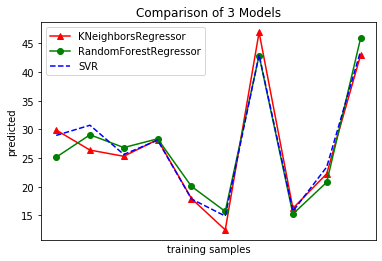

In [36]:
preds=[y_pred_knr, y_pred_rfr, y_pred_svr]
models=['KNeighborsRegressor','RandomForestRegressor','SVR']
plt.figure()
for pred, model, style in zip(preds, models,['r^-','go-','b--']):
    plt.plot(pred[:10], style, label=model)

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of 3 Models')
plt.show()

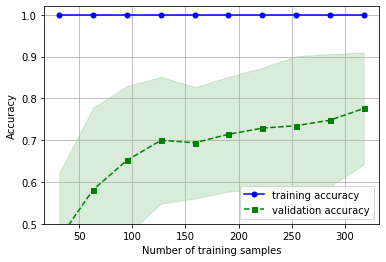

In [19]:
pipe_knr = make_pipeline(StandardScaler(),
                        KNeighborsRegressor(algorithm='auto',n_neighbors=4,weights='distance'))
train_sizes, train_scores, test_scores =\
             learning_curve(estimator=pipe_knr, X=X_train, y=y_train,
                            train_sizes=np.linspace(0.1, 1.0, 10), cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5,
         label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s',
         markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim([0.5, 1.02])
plt.show()

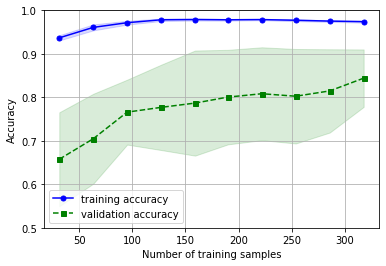

In [20]:
pipe_rfr = make_pipeline(StandardScaler(),
                        RandomForestRegressor(max_depth=9, n_estimators=100))
train_sizes, train_scores, test_scores =\
             learning_curve(estimator=pipe_rfr, X=X_train, y=y_train,
                            train_sizes=np.linspace(0.1, 1.0, 10), cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5,
         label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s',
         markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim([0.5, 1])
plt.show()

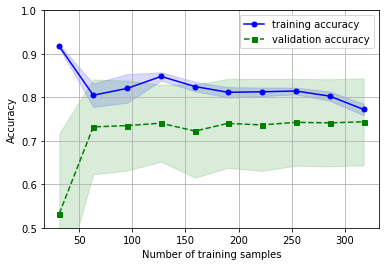

In [21]:
pipe_svr = make_pipeline(StandardScaler(),
                        SVR(C=100, epsilon=0.1, gamma=0.01, kernel='linear'))
train_sizes, train_scores, test_scores =\
             learning_curve(estimator=pipe_svr, X=X_train, y=y_train,
                            train_sizes=np.linspace(0.1, 1.0, 10), cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5,
         label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s',
         markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim([0.5, 1])
plt.show()

In [34]:
df=pd.DataFrame({'Model':['KNN','RF','SVR'],
              'MSE':[mean_squared_error(y_pred_knr,y_test), mean_squared_error(y_pred_rfr,y_test),
                    mean_squared_error(y_pred_svr,y_test)],
                'Time':[1.368, 67.087, 215.278]},index=None)
df['MSE']=round(df['MSE'],3)

In [35]:
df.transpose()

,0,1,2
Model,KNN,RF,SVR
MSE,22.599,12.497,14.069
Time,1.368,67.087,215.278
